Nama : Arsenius Anggarestu

NIM : 22.11.5180

LINK Dataset : https://www.kaggle.com/datasets/prishasawhney/mushroom-dataset

In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix
from pyspark.ml import Pipeline
from pyspark.sql.functions import corr

spark = SparkSession.builder\
    .master("local")\
    .appName("Musroom_Clasification")\
    .config('spark.ui.port', '4050')\
    .getOrCreate()

from google.colab import drive
drive.mount('/content/drive')
df = spark.read.csv("/content/drive/MyDrive/data predictive/mushroom_cleaned.csv", header=True, inferSchema=True)

Mounted at /content/drive


In [3]:
df.show()

+------------+---------+---------------+----------+-------------------+----------+----------+------------------+-----+
|cap-diameter|cap-shape|gill-attachment|gill-color|        stem-height|stem-width|stem-color|            season|class|
+------------+---------+---------------+----------+-------------------+----------+----------+------------------+-----+
|        1372|        2|              2|        10| 3.8074667544799388|      1545|        11|1.8042727086281731|    1|
|        1461|        2|              2|        10| 3.8074667544799388|      1557|        11|1.8042727086281731|    1|
|        1371|        2|              2|        10| 3.6124962945838073|      1566|        11|1.8042727086281731|    1|
|        1261|        6|              2|        10| 3.7875718095925786|      1566|        11|1.8042727086281731|    1|
|        1305|        6|              2|        10|  3.711971019020609|      1464|        11|0.9431945538974952|    1|
|        1337|        6|              2|        

#Informasi dataset :#
Cap Diameter : Menunjukkan diameter tutup jamur

Cap Shape : Menggambarkan bentuk tutup jamur, direpresentasikan sebagai nilai numerik yang mungkin sesuai dengan kategori seperti datar, bulat, cekung, dll.

Gill Attachment : Menunjukkan bagaimana insang (gill) jamur menempel pada batangnya. Nilai numerik ini kemungkinan mewakili kategori seperti bebas, melekat, dll.

Gill Color : Warna insang jamur, direpresentasikan sebagai nilai numerik yang mungkin menunjukkan warna-warna tertentu seperti putih, coklat, hitam, dll.

Stem Height : Tinggi batang jamur.

Stem Width : Lebar batang jamur.

Stem Color : Warna batang jamur, direpresentasikan sebagai nilai numerik yang mencerminkan kategori warna tertentu.

Season : Musim di mana jamur tersebut tumbuh. Nilai numerik ini mungkin mengacu pada waktu dalam tahun, seperti musim semi, musim panas, dll.

Target Class :Kategori utama dari jamur, menunjukkan apakah jamur dapat dimakan (edible) atau beracun (poisonous).

#Mencari nilai null/mising falue

In [4]:
from pyspark.sql.functions import col, isnull, when, count

df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------------+---------+---------------+----------+-----------+----------+----------+------+-----+
|cap-diameter|cap-shape|gill-attachment|gill-color|stem-height|stem-width|stem-color|season|class|
+------------+---------+---------------+----------+-----------+----------+----------+------+-----+
|           0|        0|              0|         0|          0|         0|         0|     0|    0|
+------------+---------+---------------+----------+-----------+----------+----------+------+-----+



karena tidak ditemukan missing falue dalam dataset, maka dilanjutkan dengan pengecekan tipe data.

karena tipe data dari kolom class bukan numerik maka tipe datanya diubah menjadi numerik terlebih dahulu

#Pengecekan tipe data

In [5]:
print("\nInformasi Dataset:")
df.printSchema()

print("\nStatistik Deskriptif:")
print(df.summary().show(truncate=False))


Informasi Dataset:
root
 |-- cap-diameter: integer (nullable = true)
 |-- cap-shape: integer (nullable = true)
 |-- gill-attachment: integer (nullable = true)
 |-- gill-color: integer (nullable = true)
 |-- stem-height: double (nullable = true)
 |-- stem-width: integer (nullable = true)
 |-- stem-color: integer (nullable = true)
 |-- season: double (nullable = true)
 |-- class: integer (nullable = true)


Statistik Deskriptif:
+-------+------------------+------------------+-----------------+------------------+---------------------+------------------+------------------+--------------------+------------------+
|summary|cap-diameter      |cap-shape         |gill-attachment  |gill-color        |stem-height          |stem-width        |stem-color        |season              |class             |
+-------+------------------+------------------+-----------------+------------------+---------------------+------------------+------------------+--------------------+------------------+
|count  |5403

#mengubah class menjadi tipe numerik

In [6]:
# Ubah tipe data kolom 'class' menjadi numerik (misalnya, integer atau float)
from pyspark.sql.types import IntegerType

# Assuming your 'class' column is currently of string type:
df = df.withColumn("class", df["class"].cast(IntegerType()))

# Verifikasi perubahan tipe data
df.printSchema()

root
 |-- cap-diameter: integer (nullable = true)
 |-- cap-shape: integer (nullable = true)
 |-- gill-attachment: integer (nullable = true)
 |-- gill-color: integer (nullable = true)
 |-- stem-height: double (nullable = true)
 |-- stem-width: integer (nullable = true)
 |-- stem-color: integer (nullable = true)
 |-- season: double (nullable = true)
 |-- class: integer (nullable = true)



#Korelasi Antar fitur dan Persebaran data antara jamur beracun dan tidak beracun


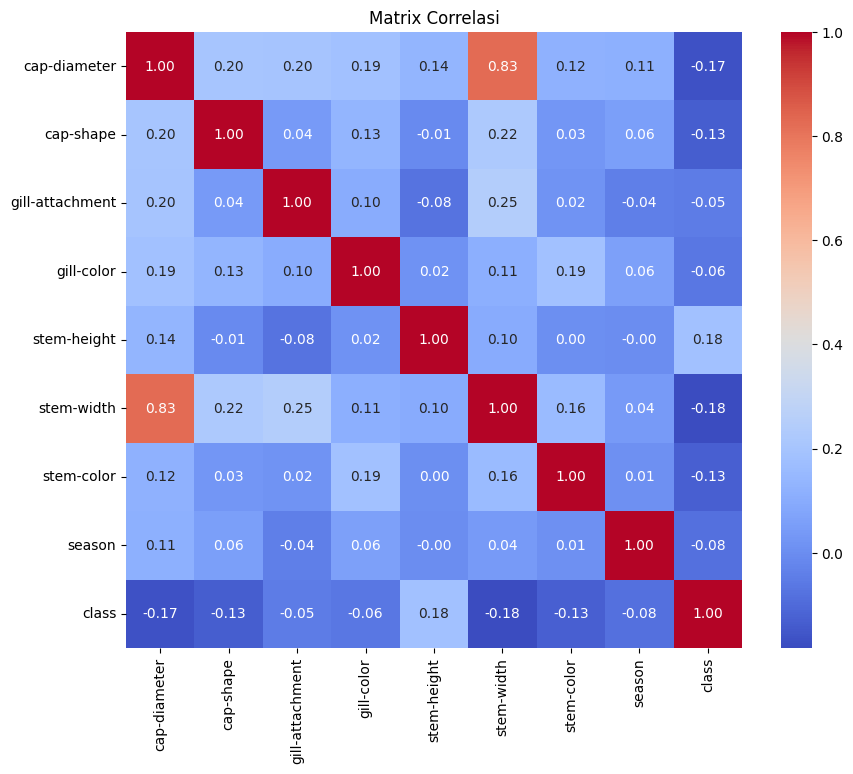

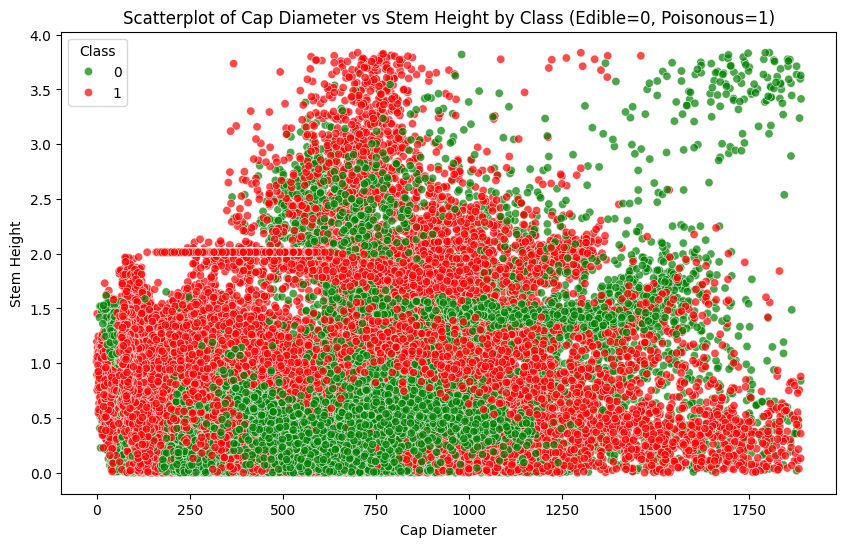

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert the PySpark DataFrame to a Pandas DataFrame first
data = df.toPandas()

# Compute and visualize the correlation matrix
correlation_matrix = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True
)
plt.title("Matrix Correlasi")
plt.show()

# Scatterplot for cap-diameter and stem-height against the class


plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=data,
    x="cap-diameter",
    y="stem-height",
    hue="class",
    palette={0: "green", 1: "red"},
    alpha=0.7
)
plt.title("Scatterplot of Cap Diameter vs Stem Height by Class (Edible=0, Poisonous=1)")
plt.xlabel("Cap Diameter")
plt.ylabel("Stem Height")
plt.legend(title="Class")
plt.show()

$Matrix Korelasi$ menampilkan kuatnya hubungan antar fitur. semakin dekan dengan warna merah maka semakin erat hubungan kedua fitur dan semakin dekat dengan warnah biru maka semakin rendah hubungan keduanya.

$Scaterplot$ menampilkan persebaran data dari jamur beracun dana tidak beracun berdasarkan *cap diameter* dan *stem height*. warna hijau menandakan jamur yang tidak beracun dan warna orange menandakan jamur beracun.



#Seleksi fitur

In [14]:
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

    # Load dataset
df = pd.read_csv('/content/drive/MyDrive/data predictive/mushroom_cleaned.csv')
X = df[['cap-diameter','cap-shape', 'gill-attachment', 'gill-color', 'stem-height', 'stem-width', 'stem-color', 'season', 'class']]
y = df['class']

X = X.abs()

# Terapkan SelectKBest dengan chi-squared
bestfeatures = SelectKBest(score_func=chi2, k=5) # Pilih 5 fitur terbaik
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
print(featureScores.nlargest(5,'Score'))  # Tampilkan 5 fitur dengan skor tertinggi
X = X.abs()

# Terapkan SelectKBest dengan chi-squared
bestfeatures = SelectKBest(score_func=chi2, k=5) # Pilih 5 fitur terbaik
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
print(featureScores.nlargest(5,'Score'))  # Tampilkan 5 fitur dengan skor tertinggi

          Specs         Score
5    stem-width  1.051298e+06
0  cap-diameter  3.386354e+05
8         class  2.436000e+04
6    stem-color  1.125028e+03
1     cap-shape  1.120969e+03
          Specs         Score
5    stem-width  1.051298e+06
0  cap-diameter  3.386354e+05
8         class  2.436000e+04
6    stem-color  1.125028e+03
1     cap-shape  1.120969e+03


#Pemodelan Random Forest

In [18]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import pandas as pd # Make sure pandas is imported

# Convert the PySpark DataFrame to a Pandas DataFrame first (if df is a PySpark DataFrame)
data = df

# Features and target
X = data.drop(columns=['class'],axis=1)  # Memisahkan fitur dari target
y = data['class']  # Target class (0 = edible, 1 = poisonous)


In [19]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42  # 80% training, 20% testing
)

In [20]:
# Train a Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)  # Inisialisasi model Random Forest dengan seed untuk reprodusibilitas
rf_model.fit(X_train, y_train)  # Melatih model dengan data training

RandomForestClassifier(random_state=42)

In [21]:
# Predictions
y_pred = rf_model.predict(X_test)  # Melakukan prediksi pada data testing

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)  # Menghitung akurasi model
f1 = f1_score(y_test, y_pred)  # Menghitung F1-Score model
report = classification_report(y_test, y_pred)  # Menghasilkan laporan klasifikasi

# Display evaluation results
print("Accuracy:", accuracy)
print("F1-Score:", f1)
print("Classification Report:\n", report)

Accuracy: 0.9909318034607199
F1-Score: 0.9916977295831921
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4909
           1       0.99      0.99      0.99      5898

    accuracy                           0.99     10807
   macro avg       0.99      0.99      0.99     10807
weighted avg       0.99      0.99      0.99     10807



Class diubah menjadi target dan sisanya menjadi fitur. data dibagi menjadi 2 dengan perbandingan data training dan data testing 8:2 .

Dari hasil evaluasi tersebut didapatkan hasil sebagi berikut:

Akurasi model: 99.09%

F1-Score: 99.16%

#Evaluasi model

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Akurasi: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"ROC AUC: {roc_auc}")

Akurasi: 0.9909318034607199
Precision: 0.9910260751777853
Recall: 0.9923702950152594
F1-Score: 0.9916977295831921
ROC AUC: 0.9907868993919239
